# Insights Into Urban Lead Water Contamination via Geographically Weighted Regression: A Case Study of Pittsburgh, Pennsylvania

# Abstract

Since the Flint Water Crisis in 2015, thousands of community water systems accross the United States have failed to meet federal drinking water standards with respect to lead contamination. While over 18 million Americans live in areas serviced by these water systems, it is unknown exactly how many households are actually at risk for lead contamination. For this reason, measures taken by water utilities to come into compliance with the Environmental Protection Agency's Lead and Copper Rule (LCR) have included residential tap water sampling and the development of lead service line (LSL) inventories. Geographic data on lead plumbing and water lead levels (WLLs) improves our understanding of lead in drinking water by helping to explain household-to-household and neighborhood-to-neighborhood variation. This study aims to model the spatial distribution and variability of water lead levels throughout the City of Pittsburgh using geographically weighted regression (GWR). The results demonstrate that a non-stationary modeling approach more accurately predicts water lead levels, in part because it accounts for a greater share of the variation in the voluntary residential water testing data. Aggregate water lead levels are estimated at the census block group level and primary as well as simulated data are presented in the form of an interactive online map. 

# Introduction

# Data

## Voluntary Residential Tap Water Sampling

Our primary data are results from voluntary residential tap water sampling between February 2016 and July 2019, the combination of two datasets released by the Pittsburgh Water and Sewer Authority released in the summers of 2017 and 2019 [[PWSA Data](http://lead.pgh2o.com/resources/customer-water-quality-data/)]. Each observation is the lead concentration in parts per billion measures at an individual household. However, the results were released by block rather than unit-number to protect the privacy of customers. Therefore, any lead levels detected at houses on a particular block were georeferenced to the first existing address on that block. In other words, samples taken on the 500 block of Main Street would be matched to the geographic coordinates of the first existing address between 500 and 599 Main Street. The geocoding algorithm (see Appendix) successfully matched coordinates to 89 percent of the block-level addresses in the dataset and allows us to spatially aggregate the data to a lower geographic resolution.

In [3]:
pgh_wlls = pd.read_csv('Primary Data/PGH_WLLS_GEOCODED_1619.csv')

pgh_wlls = gpd.GeoDataFrame(pgh_wlls[['ANALYZED ON',
                                        'LEAD RESULT',
                                        'Address',
                                        'X',
                                        'Y']].rename(columns={'Address':'Block'}), 
                            geometry=[shapely.geometry.Point((pgh_wlls.X[i],pgh_wlls.Y[i])) for i in pgh_wlls.index])

pgh_wlls[['ANALYZED ON','Block','LEAD RESULT','geometry']].head()

,ANALYZED ON,Block,LEAD RESULT,geometry
0,2018-01-30,900 Haller St,2.0,POINT (-80.0306786259011 40.4900373360844)
1,2018-01-30,800 FARRAGUT ST.,3.5,POINT (-79.9199406752406 40.46957543267001)
2,2018-01-15,100 Riverview Ave,34.0,POINT (-79.8541791827807 40.50159178477411)
3,2018-01-15,100 Riverview Ave,2.0,POINT (-79.8541791827807 40.50159178477411)
4,2018-03-07,5300 Beeler St,2.6,POINT (-79.93519314141841 40.4455779112209)


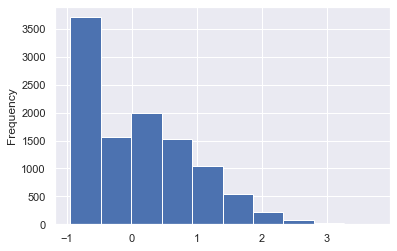

In [4]:
import scipy
from scipy.stats import rankdata, norm

Pb_normal_scores = norm.ppf(rankdata(pgh_wlls['LEAD RESULT'])/(len(pgh_wlls['LEAD RESULT']) + 1))

pgh_wlls['Pb_norm'] = Pb_normal_scores
pgh_wlls['Pb_norm'].plot.hist()

## Lead Service Line Inventory

Another relevant source of geographic data is the PWSA's LSL inventory, which consists of digitized historical records and curb box inspection results released in July 2018 [PWSA Lead Map](http://lead.pgh2o.com/your-water-service-line/planned-water-service-line-replacement-map/). The data indicate for over 47 thousand households the composition of the public and private portions of water service lines, which are the pipes that connect the water main to a home's interior plumbing. Observations were recoded to 'Lead,' 'Non-Lead,' or 'Unknown' based on these values. 

In [5]:
pwsa = pd.read_csv('C:/Users/raana/OneDrive/Desktop/Pitt/THESIS/Code/PWSA_data.csv')
pwsa = gpd.GeoDataFrame(pwsa, 
                        geometry=[shapely.geometry.Point((pwsa.x[i],pwsa.y[i])) for i in pwsa.index])

pb = []
for i in pwsa.index:
    
    x = pwsa['PublicSide_PrivateSide'][i].split(" / ")
    
    if len(x) == 2:
        y, z = x
        if y == 'Lead' or z == 'Lead':
            pb.append('Lead')
        elif y == 'Galvanized Iron' or z == 'Galvanized Iron':
            pb.append('Lead')
        elif y == 'Non-Lead' and z == 'Non-Lead':
            pb.append('Non-Lead')
        else:
            pb.append('Unk')
    else:
        pb.append('Unk')
        
pwsa['LSL'] = pb
print('Total observations: '+str(len(pwsa.dropna(subset=['LSL']))))
print(pwsa['LSL'].value_counts())
pwsa[['PublicSide_PrivateSide','LSL','Material_Source','geometry']].head()

Total observations: 47958
Lead        27829
Non-Lead    14171
Unk          5958
Name: LSL, dtype: int64


,PublicSide_PrivateSide,LSL,Material_Source,geometry
0,Non-Lead / Non-Lead,Non-Lead,Historical Record,POINT (-79.98742415 40.44381645)
1,Non-Lead / Lead,Lead,Historical Record,POINT (-79.92347873999999 40.42678981)
2,Non-Lead / Non-Lead,Non-Lead,Historical Record,POINT (-79.95927521 40.43703056)
3,Non-Lead / No Data,Unk,Historical Record,POINT (-79.92704836999999 40.42399145)
4,Non-Lead / Non-Lead,Non-Lead,Historical Record,POINT (-80.03491750000001 40.43091958)


## Residential Housing Age and Occupancy
Additionally, we consider the age and occupancy status of properties throughout Pittsburgh. This data comes from the 2017 American Community Survey (5 year estimates) for Allegheny County, PA and was downloaded at the Census block group level from [American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml). The file contains estimates for the total number of vacant and occupied housing units, the total built per decade, and the estimated median year built. The proportion of units built in each time period (e.g., 1940-1949) and percent occupied or vacant were calculated to produce ratio data for each Census block group.

In [6]:
med_yb = pd.read_csv('ACS_17_5YR_B25035_with_ann.csv', header=1)
med_yb['Id2'] = med_yb.Id2.astype(str)
x=[]
for i in med_yb['Estimate; Median year structure built']:
    try:
        x.append(int(i))
    except ValueError:
        x.append(np.nan)
med_yb['Estimate; Median year structure built'] = x

for i in pd.read_csv('ACS_17_5YR_B25034_with_ann.csv', header=1).columns[3:]:
    if 'Estimate' in i:
        med_yb[i] = pd.read_csv('ACS_17_5YR_B25034_with_ann.csv', header=1)[i]

for i in pd.read_csv('ACS_17_5YR_B25002_with_ann.csv', header=1).columns[3:]:
    if 'Estimate' in i and i != 'Estimate; Total:':
        med_yb[i] = pd.read_csv('ACS_17_5YR_B25002_with_ann.csv', header=1)[i]
        
for i in med_yb.columns[6:]:
    col = 'Perc. '+i.split(' - ')[1]
    med_yb[col] = med_yb[i] / med_yb['Estimate; Total:']
    
x = 0
for i in med_yb.columns:
    print(str(x) + " " + i)
    x+=1

0 Id
1 Id2
2 Geography
3 Estimate; Median year structure built
4 Margin of Error; Median year structure built
5 Estimate; Total:
6 Estimate; Total: - Built 2014 or later
7 Estimate; Total: - Built 2010 to 2013
8 Estimate; Total: - Built 2000 to 2009
9 Estimate; Total: - Built 1990 to 1999
10 Estimate; Total: - Built 1980 to 1989
11 Estimate; Total: - Built 1970 to 1979
12 Estimate; Total: - Built 1960 to 1969
13 Estimate; Total: - Built 1950 to 1959
14 Estimate; Total: - Built 1940 to 1949
15 Estimate; Total: - Built 1939 or earlier
16 Estimate; Total: - Occupied
17 Estimate; Total: - Vacant
18 Perc. Built 2014 or later
19 Perc. Built 2010 to 2013
20 Perc. Built 2000 to 2009
21 Perc. Built 1990 to 1999
22 Perc. Built 1980 to 1989
23 Perc. Built 1970 to 1979
24 Perc. Built 1960 to 1969
25 Perc. Built 1950 to 1959
26 Perc. Built 1940 to 1949
27 Perc. Built 1939 or earlier
28 Perc. Occupied
29 Perc. Vacant


## Area Deprivation Index
Finally, we include the Area Deprivation Index (ADI) ranking for each census block group in Pittsburgh. The ADI is a composite measure of socioeconomic disadvantage covering the domains of income, employment, educational attainment and housing quality [link]. Neighborhoods (block groups) with the lowest ranking (100) represent the most socioeconomically disadvantaged in the country.

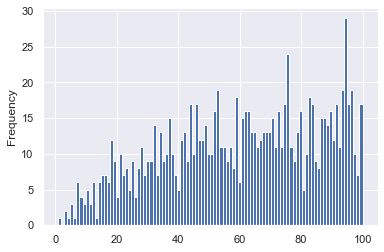

In [8]:
PA_blocks = gpd.read_file("tl_2017_42_bg.shp")
adi = pd.read_csv('Secondary Data/US_blockgroup_15.csv')
county = []
for i in adi.index:
    x = str(adi.fips[i])[0:5]
    county.append(x)
adi['county'] = county
adi = adi[adi.county == '42003'] # Allegheny County
adi['fips'] = adi['fips'].astype(str)
PA_blocks['fips'] = PA_blocks['GEOID'].astype(str)
adi = gpd.GeoDataFrame(pd.merge(adi, PA_blocks[['fips','geometry']], how='left',on='fips'))
nr = []
for i in adi.index:
    if adi.adi_natrank[i] in ['GQ', 'GQ-PH', 'PH']:
        nr.append(np.nan)
    else:
        nr.append(int(adi.adi_natrank[i]))
adi['adi_natrank'] = nr
adi.adi_natrank.plot.hist(bins=100)

# Methods

### Aggregation
To match each of our variables to a common geographic location, we spatially aggregate the point-level lead data to the Census Block Group. This allows us to see how the outcome and predictors vary across the city, from neighborhood to neighborhood. Within each subdivision of Pittsburgh, we calculate the median, standard deviation and mean absolute deviation of lead test results in parts per billion. For the LSL data, which is categorical, we use the proportion of LSLs to Non-LSLs for those houses where the composition is known on the public and private sides. Once all of the data is at a consistent geographic scale, we match the aggregated variables to housing age and socioeconomic data by twelve-digit block group ID.

In [ ]:
adi = pd.merge(adi[['fips','adi_natrank']], PA_blocks, on='fips',how='inner')
adi_acs = pd.merge(adi, med_yb.rename(columns={'Id2':'fips'}), on='fips', how='inner')

In [10]:
# Assign a FIPS block group ID to each observation via spatial join
pwsa = sjoin(pwsa, gpd.GeoDataFrame(adi_acs[['fips','geometry']]),how='inner',op='intersects')
pgh_wlls = sjoin(pgh_wlls.dropna(subset=['X']), gpd.GeoDataFrame(adi_acs[['fips','geometry']]),how='inner',op='intersects')

nPb, meanPb, medianPb, stdPb, madPb = [],[],[],[],[]
nSL, nLSL, nNLSL, pct1 = [], [], [], []
fails = []
x = 0
f = 0
for i in adi_acs.fips:
    print('Progress: {:.2%}   Fails {}'.format(x/len(adi_acs),f), end='\r')
    x += 1
    
    
    try:
        block_props = pgh_wlls[pgh_wlls.fips==i]
        if 'Pb_norm' in block_props.columns:
            stats  = block_props['Pb_norm'].describe()
            nPb.append(stats[0])
            meanPb.append(stats[1])
            medianPb.append(stats[4])
            stdPb.append(stats[2])
            madPb.append(block_props['Pb_norm'].mad())

    except:
        #print('Fail at {}: pgh_wlls'.format(x))
        nPb.append(np.nan)
        meanPb.append(np.nan)
        medianPb.append(np.nan)
        stdPb.append(np.nan)
        madPb.append(np.nan)
        f+=1
        
    try:
        block_props = pwsa[pwsa.fips==i]
        if 'LSL' in block_props.columns:
            nSL.append(len(block_props[block_props.LSL.isin(['Lead','Non-Lead'])]))
            nLSL.append(len(block_props[block_props.LSL=='Lead']))
            nNLSL.append(len(block_props[block_props.LSL=='Non-Lead']))
            if len(block_props[block_props.LSL.isin(['Lead','Non-Lead'])]) > 0:
                pct1.append(len(block_props[block_props.LSL=='Lead'])/len(block_props[block_props.LSL.isin(['Lead','Non-Lead'])]))
            else:
                pct1.append(np.nan)
        
    except:
        #print('Fail at {}: pwsa'.format(x))
        nSL.append(np.nan)
        nLSL.append(np.nan)
        nNLSL.append(np.nan)
        pct1.append(np.nan)
        if f != y:
            f+=1
df = pd.DataFrame({'fips':[i for i in adi_acs.fips],
                   'nPb':nPb, 'meanPb':meanPb, 'medianPb':medianPb,' stdPb':stdPb, 'madPb':madPb, 
                   'nSL':nSL, 'nLSL':nLSL, 'nNLSL':nNLSL, 'pct1':pct1})

agg_df = gpd.GeoDataFrame(pd.merge(df, adi_acs[['fips',
                                                'adi_natrank',
                                                'Estimate; Total:',
                                                'Estimate; Median year structure built',
                                                'Perc. Built 2014 or later', 
                                                'Perc. Built 2010 to 2013',
                                                'Perc. Built 2000 to 2009', 'Perc. Built 1990 to 1999',
                                                'Perc. Built 1980 to 1989', 'Perc. Built 1970 to 1979',
                                                'Perc. Built 1960 to 1969', 'Perc. Built 1950 to 1959',
                                                'Perc. Built 1940 to 1949', 'Perc. Built 1939 or earlier', 
                                                'Perc. Occupied', 
                                                'Perc. Vacant', 
                                                'geometry']], 
                                   on='fips', how='left'))
agg_df.head()
psa = gpd.read_file('C:/Users/raana/OneDrive/Desktop/Pitt/THESIS/GIS/pwsa_service_area/pwsa_water_service_area.shp')
agg_df = gpd.overlay(psa, agg_df, how='intersection')

C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\geopandas\base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  other.crs))


### Geospatial Analysis of Outcome and Predictor Variables



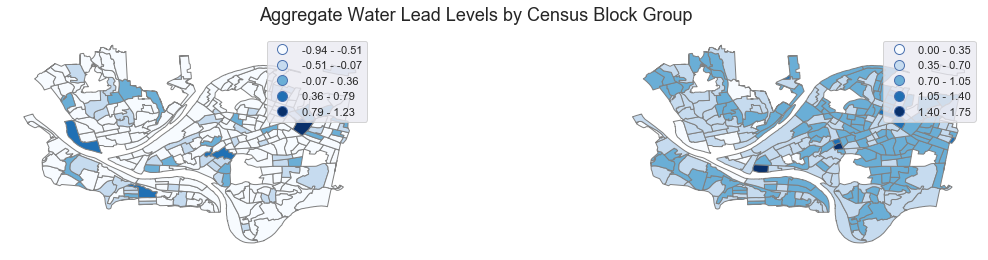

In [102]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
fig.suptitle('Aggregate Water Lead Levels by Census Block Group', fontsize=18)

ax1 = agg_df.dropna(subset=['medianPb']).plot(column='medianPb', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey',legend=True, ax=ax1)
ax2 = agg_df.dropna(subset=['madPb']).plot(column='madPb', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey', legend=True, ax=ax2)

for ax in [ax1,ax2]:
    ax.set_axis_off()

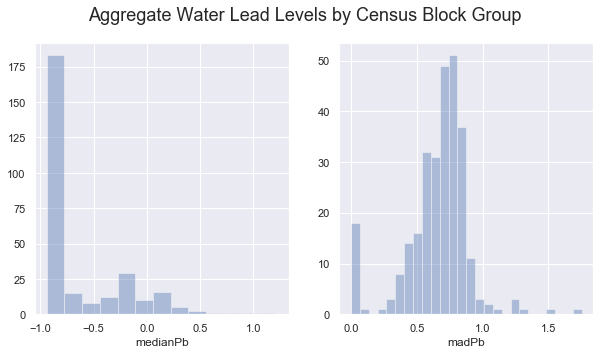

In [163]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Aggregate Water Lead Levels by Census Block Group', fontsize=18)
ax1 = sns.distplot(agg_df.dropna(subset=['medianPb'])['medianPb'],ax=ax1, kde=False)
ax2 = sns.distplot(agg_df.dropna(subset=['madPb'])['madPb'],ax=ax2, kde=False)

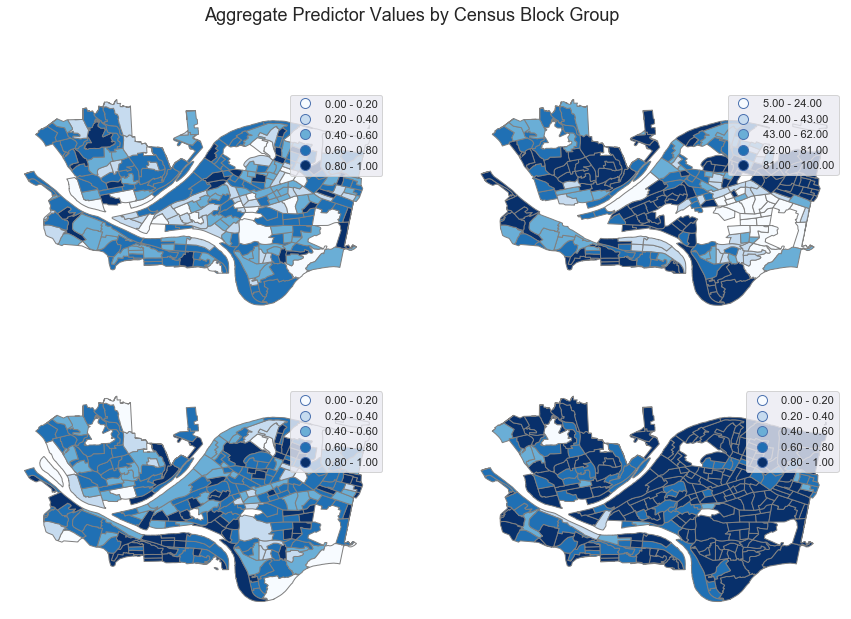

In [155]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Aggregate Predictor Values by Census Block Group', fontsize=18)

ax1 = agg_df.dropna(subset=['Perc. Built 1939 or earlier']).plot(column='Perc. Built 1939 or earlier', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey', legend=True, ax=ax1)
ax2 = agg_df.dropna(subset=['adi_natrank']).plot(column='adi_natrank', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey', legend=True, ax=ax2)
ax3 = agg_df.dropna(subset=['pct1']).plot(column='pct1', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey', legend=True, ax=ax3)
ax4 = agg_df.dropna(subset=['Perc. Occupied']).plot(column='Perc. Occupied', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey', legend=True, ax=ax4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_off()

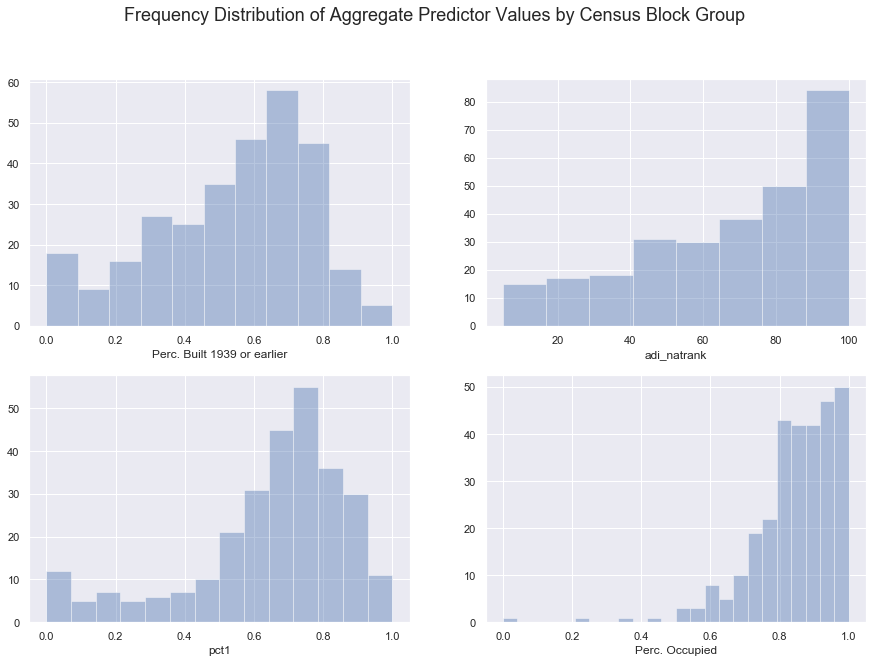

In [161]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Frequency Distribution of Aggregate Predictor Values by Census Block Group', fontsize=18)
ax1 = sns.distplot(agg_df.dropna(subset=['Perc. Built 1939 or earlier'])['Perc. Built 1939 or earlier'], ax=ax1, kde=False)
ax2 = sns.distplot(agg_df.dropna(subset=['adi_natrank'])['adi_natrank'], ax=ax2, kde=False)
ax3 = sns.distplot(agg_df.dropna(subset=['pct1'])['pct1'], ax=ax3, kde=False)
ax4 = sns.distplot(agg_df.dropna(subset=['Perc. Occupied'])['Perc. Occupied'], ax=ax4, kde=False)

In [120]:
agg_df.columns

Index(['OBJECTID', 'AREA', 'PERIMETER', 'BOUNDARY_', 'BOUNDARY_I',
       'Shape_Leng', 'fips', 'nPb', 'meanPb', 'medianPb', ' stdPb', 'madPb',
       'nSL', 'nLSL', 'nNLSL', 'pct1', 'adi_natrank', 'Estimate; Total:',
       'Estimate; Median year structure built', 'Perc. Built 2014 or later',
       'Perc. Built 2010 to 2013', 'Perc. Built 2000 to 2009',
       'Perc. Built 1990 to 1999', 'Perc. Built 1980 to 1989',
       'Perc. Built 1970 to 1979', 'Perc. Built 1960 to 1969',
       'Perc. Built 1950 to 1959', 'Perc. Built 1940 to 1949',
       'Perc. Built 1939 or earlier', 'Perc. Occupied', 'Perc. Vacant',
       'geometry'],
      dtype='object')

In [127]:
agg_df[['fips',
        'nPb','medianPb',
        'adi_natrank',
        'pct1',
        'Estimate; Total:',
        'Perc. Built 1939 or earlier',
        'Perc. Occupied',
        'geometry']].drop_duplicates(subset='fips').to_file('Synthetic Data/AGG_PGH_GWR_output.shp')

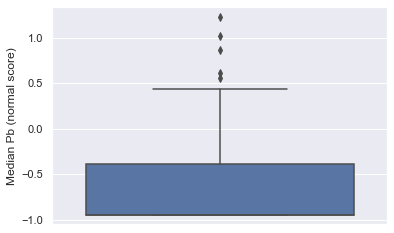

In [154]:
sns.boxplot(y="Median Pb (normal score)", data=agg_df.rename(columns={'medianPb':'Median Pb (normal score)'}))
#sns.stripplot(y="medianPb", data=agg_df, color="black", jitter=0.2, size=3.5)

# Results

### Local Moran's I

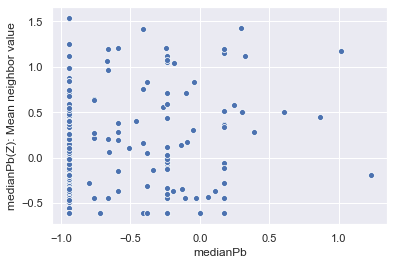

In [165]:
"""
SpaceStat Output:

Univariate local Moran method:

Input parameters:
Dataset = AGG_PGH_GWR_nonan: medianPb
Number of randomizations = 999
Spatial weight set = Queen neighbors
Alpha level = 0.05
Use Simes correction = Yes

Moran's I,   P value
0.139206,    0.001000

"""
morans = lr_results[['fips', 'medianPb', 'medianPb(Z)','medianPb(Z): Mean neighbor value', 
                     'medianPb(Z): Ii', 'medianPb(Z): High/Low', 'medianPb(Z): P value']]
sns.scatterplot(x="medianPb", y="medianPb(Z): Mean neighbor value", data=morans)

### Geographically Weighted Regression

       Aspatial Regression Results:                              Geographically Weighted Regression Results:

       Corr. coeff. (r):  0.258885                                Corr. coeff. (r): 0.479099


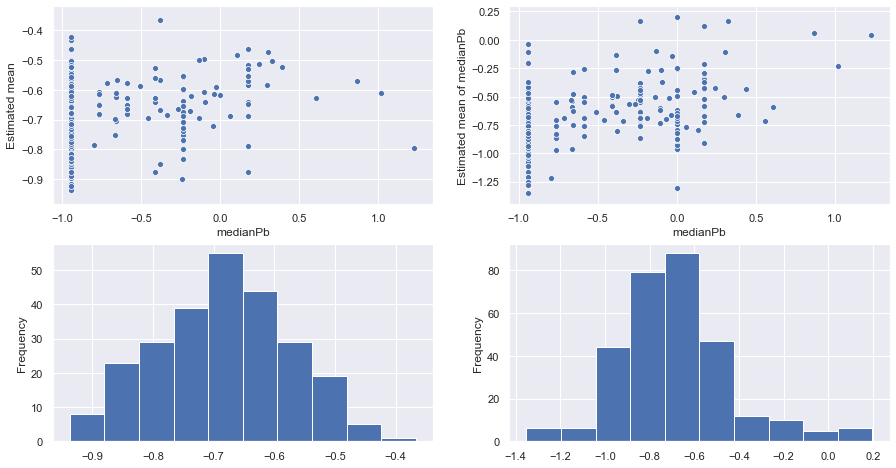

In [153]:
lr_results = pd.read_csv('Synthetic Data/GWR_Results-1-31-20/asp_moransI_results.csv')
#for col in lr_results[lr_results.columns[3:]].drop_duplicates(subset='fips').columns:
#    print(col)
gwr_results = pd.read_csv('Synthetic Data/GWR_Results-1-31-20/GWR_results.csv')
#for col in gwr_results[gwr_results.columns[3:]].drop_duplicates(subset='fips').columns:
#    print(col)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
ax1 = sns.scatterplot(x="medianPb", y="Estimated mean", data=lr_results, ax=ax1)
ax2 = sns.scatterplot(x="medianPb", y="Estimated mean of medianPb", data=gwr_results, ax=ax2)
ax3 = lr_results['Estimated mean'].plot.hist(ax=ax3)
ax4 = gwr_results['Estimated mean of medianPb'].plot.hist(ax=ax4)
print('       Aspatial Regression Results:                              Geographically Weighted Regression Results:\n')
print('       Corr. coeff. (r):  0.258885                                Corr. coeff. (r): 0.479099')

# Discussion

1. Local Moran's I result

2. 

# Conclusions

# Appendix

In [2]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import datetime
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import shapely
from shapely import geometry
import json
import geopandas as gpd
from geopandas.tools import sjoin
import math

In [ ]:
# Geocoding method using WRPDC geo API
def geocode(address):
    # Store address-specific links in link to run through web-scraping algorithm
    link = "https://tools.wprdc.org/geo/geocode/?addr="+address
    
    # create list of neighboring addresses
    add = address.split(" ")
    neighbors = []
    for i in range(1,51):
        neighbor = str(int(add[0])+i)
        for a in range(1,len(add)):
            neighbor = neighbor + " " + add[a]
        neighbors.append(neighbor)
        
    # Get html source from API search
    r = requests.get(link) 
    # Get full data vector from API
    soup = BeautifulSoup(r.content, "html.parser")
    
    
    # Make sure there is coordinate data
    if "ERROR" in str(soup): 
        
        # Try the neighbors:
        for i in range(0,len(neighbors)):
            link = "https://tools.wprdc.org/geo/geocode/?addr="+neighbors[i]
            r = requests.get(link)
            soup = BeautifulSoup(r.content, "html.parser")
            if "ERROR" not in str(soup):
                # Split String output by delimiters to isolate x and y coordinates
                xy = str(soup).split("[")[1].split("]")[0].split(", ")
                
                # Isolated and assign lat/long coordinates to x and y
                x, y = float(xy[0]), float(xy[1])
                result = 1
                break
            else:
                if i == len(neighbors) - 1:
                    x, y = np.nan, np.nan
                    result = 0
                else:
                    continue
        
    else: 
        # Split String output by delimiters to isolate x and y coordinates
        xy = str(soup).split("[")[1].split("]")[0].split(", ")
        x, y = float(xy[0]), float(xy[1])
        result = 1

        
    xy = tuple([x,y])
    
    return xy, result

# References